In [33]:
# imports
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12}) 
import ast
import uproot as ur4
from tqdm import tqdm 
from scipy.optimize import curve_fit 
import scipy.integrate as integrate
import scipy.signal
import iminuit
from scipy.special import erf
import pprint
import pickle
import random
from os.path import exists
from lmfit import Model
from lmfit import Parameters, minimize
from scipy.optimize import minimize
from iminuit import Minuit
from scipy.stats import norm

In [34]:
global Settings
Settings = {}

def SettingsClear():
    global Settings
    Settings = {}

global ColorBook
ColorBook = {
                "Main Fit" : "magenta",
                "Data" : "blue",
                "Add-Ons" : "slategrey",
                "lmfit" : "magenta",
                "curvefit" : "red",
                0 : "forestgreen",
                1 : "darkorange",
                2 : "peru",
                3 : "greenyellow"
            }

global Histogram
Histogram = {"hist": [], "bins": []}

global SetIntegrationConstant
SetIntegrationConstant = 1

In [35]:
def exponential(x, x_0, n_i, tau_i):
    return (n_i / 1) * np.exp(-(x - x_0)/tau_i)

def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-((x-mean)**2)/(2*(sigma**2)))

def gauss(x,x0):
    gauss_result = np.exp(-(x-x0)**2/(2*(Settings["Fixed Parameters"]["Detector Resolution"]**2)))
    gauss_result = gauss_result/integrate.simpson(gauss_result,dx=np.diff(x)[0])

    return gauss_result

def sum_of_exp(x, x0, n0, tau0, n1, tau1, n2, tau2, n3, tau3):
    sum_of_exp_result = (   (n0 / 1) * np.exp(-(x-x0)/tau0) +
                            (n1 / 1) * np.exp(-(x-x0)/tau1) +
                            (n2 / 1) * np.exp(-(x-x0)/tau2) +
                            (n3 / 1) * np.exp(-(x-x0)/tau3)  
                        )
    return sum_of_exp_result

def convolve_single(x, x0, x1, n0, tau0):
    exp_result = exponential(x, x1, n0, tau0)
    gauss_result = gauss(x,x0)
    return scipy.signal.convolve(gauss_result, exp_result, mode='full')[0:len(x)]

def convolution_model(x, x0, x1, n0, tau0, n1, tau1, n2, tau2, n3, tau3):
    exp_result = sum_of_exp(x, x1, n0, tau0, n1, tau1, n2, tau2, n3, tau3)
    gauss_result = gauss(x, x0)

    return np.convolve(exp_result, gauss_result, mode='full')[0:len(x)]


def partexp_convolution_wbls(x, x0, x1, c, n0, tau0, tau1, tauR):
    x1_in = 0
    exp_result =    n0  * ((np.exp(-(x-x1_in)/tau0)-np.exp(-(x-x1_in)/tauR))/(tau0 - tauR)) + \
                 (1-n0) * ((np.exp(-(x-x1_in)/tau1)-np.exp(-(x-x1_in)/tauR))/(tau1 - tauR))
    gauss_result = gauss(x, x1)

    return np.heaviside(x,0.5) * (1-c) * np.convolve(exp_result,gauss_result,mode="full")[0:len(x)]

def partgauss_convolution_wbls(x, x0, x1, c, n0, tau0, tau1, tauR):
    x1_in = 0
    gauss_result = gauss(x, x0)

    return  np.heaviside(x,0.5) * c * gauss_result

def convolution_wbls(x, x0, x1, c, n0, tau0, tau1, tauR):
    x1_in = 0
    exp_result =    n0  * ((np.exp(-(x-x1_in)/tau0)-np.exp(-(x-x1_in)/tauR))/(tau0 - tauR)) + \
                 (1-n0) * ((np.exp(-(x-x1_in)/tau1)-np.exp(-(x-x1_in)/tauR))/(tau1 - tauR))
    gauss_result = gauss(x, x1)

    return np.heaviside(x,0.5)*(c * gauss(x, x0) + (1-c) * np.convolve(exp_result,gauss_result,mode="full")[0:len(x)])



In [36]:
def GetBranchFromTree(filename,branchname):
    myFile = ur4.open(filename)
    nparray = np.array(myFile[Settings["Files"]["Treename"]][branchname].array())
    myFile.close()
        
    return nparray

def checktype(value):
    if value.startswith('['):
        return ast.literal_eval(value)

    if value.isnumeric():
        return int(value)

    if '.' in value:
        splits = value.split('.',-1)
        if len(splits) == 2 and splits[0].isnumeric() and splits[1].isnumeric():
            return float(value)
        else:
            return value

    if '-' in value:
        splits = value.split('-',-1)
        if len(splits)>1 and splits[0]!='':
            return value
        else: 
            if '.' in value:
                return float(value)
            else:
                return int(value)
    return value

def LoadSettings(setfile):
    #Load Settings file
    print("Using "+setfile+" as Settings")
    with open(setfile, "r") as open_file:
        for line in open_file.readlines():
            if line.startswith('#') or len(line)<=1 or line.isspace():
                continue
            elif line.startswith('+'):  
                upper_key = line.strip("+").strip('\n')
            else:
                [lower_key,str_value] = line.split(" = ")
                value = checktype(str_value.strip('\n'))
                if upper_key not in Settings:
                    Settings.update({upper_key:{lower_key:value}})
                else:
                    Settings[upper_key].update({lower_key:value})
    open_file.close()

def Normalize(data):
    result = integrate.simpson(data, dx=(Settings['Histogram']['Bin End']-Settings['Histogram']['Bin Start'])/Settings['Histogram']['NBins'])
    norm_data = data/result
    return norm_data

def PrettyPrintForCureFit(popt,pcov,names):
    for enum,i in enumerate(range(len(popt))):
        print(f"{names[i]}: {popt[i]} +/- {np.sqrt(pcov[i,i])}")

def Use_lmfit(x_subset, y_subset):
    # Create lmfit Model
    model = Model(convolution_model)

    # Create lmfit Parameters object
    lower = Settings["Fit"]["Lower"]
    upper = Settings["Fit"]["Upper"]
    params_init = Parameters()
    params_init.add('x0',   value=float(Settings['Fit']['Initial X0']),     min=-200,                                       max=200)
    params_init.add('x1',   value=float(Settings['Fit']['Initial X1']),     min=-200,                                       max=200)
    params_init.add('n0',   value=float(Settings['Fit']['Initial N0']),     min=lower*float(Settings['Fit']['Initial N0']),   max=1)
    params_init.add('tau0', value=float(Settings['Fit']['Initial Tau0']),   min=lower*float(Settings['Fit']['Initial Tau0']), max=upper*float(Settings['Fit']['Initial Tau0']))
    params_init.add('n1',   value=float(Settings['Fit']['Initial N1']),     min=lower*float(Settings['Fit']['Initial N1']),   max=1)
    params_init.add('tau1', value=float(Settings['Fit']['Initial Tau1']),   min=lower*float(Settings['Fit']['Initial Tau1']), max=upper*float(Settings['Fit']['Initial Tau1']))
    params_init.add('n2',   value=float(Settings['Fit']['Initial N2']),     min=lower*float(Settings['Fit']['Initial N2']),   max=1)
    params_init.add('tau2', value=float(Settings['Fit']['Initial Tau2']),   min=lower*float(Settings['Fit']['Initial Tau2']), max=upper*float(Settings['Fit']['Initial Tau2']))
    params_init.add('n3',   value=float(Settings['Fit']['Initial N3']),     min=lower*float(Settings['Fit']['Initial N3']),   max=1)
    params_init.add('tau3', value=float(Settings['Fit']['Initial Tau3']),   min=lower*float(Settings['Fit']['Initial Tau3']), max=upper*float(Settings['Fit']['Initial Tau3']))

    result = model.fit(y_subset, params_init, x=x_subset, method=Settings["Fit"]["Method"])

    param_values = [result.params[param].value for param in result.params]
    param_errors = [result.params[param].stderr for param in result.params]
    
    return result,param_values,param_errors

def Use_curvefit(x_subset, y_subset):
    params_bounds =   [
                        [
                            -200, -200, 0, 0, 0, 0, 0, 0, 0, 0
                        ],
                        [
                            200, 200, 
                            1.0, float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial Tau0']),
                            1.0, float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial Tau1']),
                            1.0, float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial Tau2']),
                            1.0, float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial Tau3']),
                        ]
                    ]
    params_init =   np.array([
                        Settings['Fit']['Initial X0'],Settings['Fit']['Initial X1'],
                        Settings['Fit']['Initial N0'],Settings['Fit']['Initial Tau0'],
                        Settings['Fit']['Initial N1'],Settings['Fit']['Initial Tau1'],
                        Settings['Fit']['Initial N2'],Settings['Fit']['Initial Tau2'],
                        Settings['Fit']['Initial N3'],Settings['Fit']['Initial Tau3'],
                    ])*SetIntegrationConstant
    
    popt, pcov = curve_fit(convolution_model,xdata=x_subset,ydata=y_subset,p0=params_init,bounds=params_bounds,maxfev = 100000)

    return popt,pcov

def IntegrationConstant(data):
    return integrate.simpson(data,dx=(Settings['Histogram']['Bin End']-Settings['Histogram']['Bin Start'])/Settings['Histogram']['NBins'])

def Plot_Data_plus_Fit(data,fits):
    for enum,(ftype,x_fit,y_fit,fit_values,fit_errors) in enumerate(fits):
        # Plot the histogram and the fit
        ## Generate the figure
        fig = plt.figure(enum,figsize=[10,10], facecolor='white')
    
        ## Draw the histogram and the main fit
        #plt.errorbar(data[0],data[1], yerr=np.sqrt(data[1]), fmt='none', capsize=3, capthick=2, alpha=0.3,ecolor=ColorBook["Data"] ,label="Data")
        plt.plot(data[0],data[1], color=ColorBook["Data"] ,label="Data")
        plt.plot(x_fit, y_fit, c=ColorBook[ftype], ls='-', label="Fit {}".format(ftype))
        #plt.plot(x_fit, gauss(x_fit,fit_values[0]), c=ColorBook[ftype], ls='-', label="Fit {}".format(ftype))
        plt.plot(x_fit, convolve_single(x_fit,*[fit_values[0],fit_values[1],fit_values[2],fit_values[3]]), c=ColorBook[0], ls='--', label="Fit PE1-{}".format(ftype))
        plt.plot(x_fit, convolve_single(x_fit,*[fit_values[0],fit_values[1],fit_values[4],fit_values[5]]), c=ColorBook[1], ls='--', label="Fit PE2-{}".format(ftype))
        plt.plot(x_fit, convolve_single(x_fit,*[fit_values[0],fit_values[1],fit_values[6],fit_values[7]]), c=ColorBook[2], ls='--', label="Fit PE3-{}".format(ftype))
        plt.plot(x_fit, convolve_single(x_fit,*[fit_values[0],fit_values[1],fit_values[8],fit_values[9]]), c=ColorBook[3], ls='--', label="Fit PE4-{}".format(ftype))

        # del params_init
        ## Plot vertical lines for fit ranges
        plt.axvline(x=Settings['Fit']['Fit Start'], c=ColorBook["Add-Ons"], ls=':')
        plt.axvline(x=Settings['Fit']['Fit End'], c=ColorBook["Add-Ons"], ls=':')

        ## Plotsettings
        plt.xlabel("Timedifference Trigger-Pulse in ns")
        plt.xlim(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End'])

        plt.ylabel("Counts/{:.2f}ns".format((Settings['Histogram']['Bin End']-Settings['Histogram']['Bin Start'])/Settings['Histogram']['NBins']))
        if Settings["Histogram"]["Normalize"]==1:
            plt.ylim(0.0001,1)
        else:
            plt.ylim(0.1,1.5*np.max(data[1]))
        if(Settings["Histogram"]["Log"]==1):
            plt.yscale("log")

        plt.legend()
        plt.show()

In [37]:
def Do_Work_For_LAB(data):
    global SetIntegrationConstant
    data = data[(data >= -100) & (data <= 100)]
    data = data - Settings['Histogram']['Shift']

    hist_data, bin_edges = np.histogram(data, bins=Settings['Histogram']['NBins'],range=(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End']))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if(Settings["Histogram"]["Normalize"]==1):
        hist_data = Normalize(hist_data)

    Histogram.update({"hist": hist_data, "bins": bin_centers})

    mask = (bin_centers >= Settings['Fit']['Fit Start']) & (bin_centers <= Settings['Fit']['Fit End'])
    x_subset = bin_centers[mask]
    y_subset = hist_data[mask]

    if Settings["Fit"]["Type"] == "lmfit":
        result, param_values, param_errors = Use_lmfit(x_subset,y_subset)
        print(result.fit_report())
        fits_data_book = [[Settings["Fit"]["Type"],x_subset,convolution_model(x_subset,*param_values),param_values,param_errors]]
    elif Settings["Fit"]["Type"] == "curvefit":
        popt, pcov = Use_curvefit(x_subset,y_subset)
        names = ["x0","x1","n0","tau0","n1","tau1","n2","tau2","n3","tau3"]
        PrettyPrintForCureFit(popt,pcov,names)
        fits_data_book = [[Settings["Fit"]["Type"],x_subset,convolution_model(x_subset,*popt),popt,np.sqrt(np.diag(pcov))]]
    elif Settings["Fit"]["Type"] == "both":
        result, param_values, param_errors = Use_lmfit(x_subset,y_subset)
        popt, pcov = Use_curvefit(x_subset,y_subset)
        fits_data_book = [
                            ["lmfit",x_subset,convolution_model(x_subset,*param_values),param_values,param_errors],
                            ["curvefit",x_subset,convolution_model(x_subset,*popt),popt,np.sqrt(np.diag(pcov))]
                         ]
        names = ["x0","x1","n0","tau0","n1","tau1","n2","tau2","n3","tau3"]
        PrettyPrintForCureFit(popt,pcov,names)
        print(result.fit_report())

    Plot_Data_plus_Fit([bin_centers,hist_data],fits_data_book)


In [38]:
def Do_Work_for_HPLC(data):
    data = data[(data >= -100) & (data <= 100)]
    #plt.hist(data, bins=Settings['Histogram']['NBins'],range=(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End']))
    data = data - Settings['Histogram']['Shift']
    #plt.hist(data, bins=Settings['Histogram']['NBins'],range=(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End']))

    hist_data, bin_edges = np.histogram(data, bins=Settings['Histogram']['NBins'],range=(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End']))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if(Settings["Histogram"]["Normalize"]==1):
        hist_data = Normalize(hist_data)
    Histogram.update({"hist": hist_data, "bins": bin_centers})

    # Fit the convolution to the histogram data
    mask = (bin_centers >= Settings['Fit']['Fit Start']) & (bin_centers <= Settings['Fit']['Fit End'])
    x_subset = bin_centers[mask]
    y_subset = hist_data[mask]

    # Create lmfit Model
    model = Model(gaussian)

    # Create lmfit Parameters object
    params_init = Parameters()
    params_init.add('amplitude',    value=np.max(y_subset))
    params_init.add('mean',         value=x_subset[np.where(y_subset==np.max(y_subset))[0][0]])
    params_init.add('sigma',        value=float(Settings['Fit']['Initial Sigma']))

    result = model.fit(y_subset, params_init, x=x_subset)

    # Print fit statistics
    print(result.fit_report())

    x_fit = x_subset 
    y_fit = result.best_fit#convolution_model(x_fit, *params_fit)#/integrate.simpson(convolution_model(x_fit, *params_fit),dx=(Settings['Histogram']['Bin End']-Settings['Histogram']['Bin Start'])/Settings['Histogram']['NBins'])

    del params_init
    # Plot the histogram and the fit
    ## Generate the figure
    fig = plt.figure(figsize=[10,10], facecolor='white')
    
    ## Draw the histogram and the main fit
    # plt.errorbar(bin_centers, hist_data, yerr=2*np.sqrt(hist_data), fmt='none', capsize=3, capthick=2, ecolor=ColorBook["Data"] ,label="Data")
    plt.plot(bin_centers,hist_data, color=ColorBook["Data"] ,label="Data")
    plt.plot(x_fit, y_fit, c=ColorBook["Main Fit"], ls='-', label="Fit")
    
    # legend_labels = []
    # param_names = ['n0', 'tau0', 'n1', 'tau1', 'n2', 'tau2', 'n3', 'tau3']
    # print(f'X0: {popt[0]:.3f} ± {popt[0]:.3f}')

    # # Print and collect fit results for each parameter
    # for i, param_name in enumerate(param_names):
    #     value = popt[i+1]
    #     print(f'{param_name}: {value:.3f} ± {0.0:.3f}')
    #     legend_labels.append(f'{param_name}={value:.3f}±{0.0:.3f}')

    # Draw additional fits and stuff
    # for enum, part_plot in enumerate(range(1, len(param_names), 2)):
    #     params = [popt['x0'], po[part_plot], fit_results[part_plot+1]]
    #     plt.plot(x_fit, convolution_plot(x_fit, params), c=ColorBook[enum], ls='--', label=legend_labels[enum])

    ## Plot vertical lines for fit ranges
    plt.axvline(x=Settings['Fit']['Fit Start'], c=ColorBook["Add-Ons"], ls=':')
    plt.axvline(x=Settings['Fit']['Fit End'], c=ColorBook["Add-Ons"], ls=':')

    ## Plotsettings
    plt.xlabel("Timedifference Trigger-Pulse in ns")
    plt.xlim(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End'])
    plt.ylabel("Counts/{:.2f}ns".format((Settings['Histogram']['Bin End']-Settings['Histogram']['Bin Start'])/Settings['Histogram']['NBins']))
    if Settings["Histogram"]["Normalize"]==1:
        plt.ylim(0.0001,1)
    else:
        print(np.max(hist_data))
        plt.ylim(0.1,1.5*np.max(hist_data))
    plt.yscale("log")
    plt.legend()
    plt.show()

In [39]:
def Do_Work_For_WbLS(data):
    ####################################### Prepare data
    data = data[(data >= -100) & (data <= 100)]
    data = data - Settings['Histogram']['Shift']

    hist_data, bin_edges = np.histogram(data, bins=Settings['Histogram']['NBins'],range=(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End']))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    if(Settings["Histogram"]["Normalize"]==1):
        hist_data = Normalize(hist_data)

    mask = (bin_centers >= Settings['Fit']['Fit Start']) & (bin_centers <= Settings['Fit']['Fit End'])
    x_subset = bin_centers[mask]
    y_subset = hist_data[mask]

    ####################################### Create lmfit Model
    model = Model(convolution_wbls)

    lower = Settings["Fit"]["Lower"]
    upper = Settings["Fit"]["Upper"]
    params_init = Parameters()
    params_init.add('x0',   value=float(Settings['Fit']['Initial X0']),     min=-200,                                       max=200)
    params_init.add('x1',   value=float(Settings['Fit']['Initial X1']),     min=-200,                                       max=200)
    params_init.add('c',   value=float(Settings['Fit']['Initial C']),     min=lower*float(Settings['Fit']['Initial C']),   max=1)
    params_init.add('n0',   value=float(Settings['Fit']['Initial N0']),     min=lower*float(Settings['Fit']['Initial N0']),   max=1)
    params_init.add('tau0', value=float(Settings['Fit']['Initial Tau0']),   min=lower*float(Settings['Fit']['Initial Tau0']), max=upper*float(Settings['Fit']['Initial Tau0']))
    params_init.add('tau1', value=float(Settings['Fit']['Initial Tau1']),   min=lower*float(Settings['Fit']['Initial Tau1']), max=upper*float(Settings['Fit']['Initial Tau1']))
    params_init.add('tauR', value=float(Settings['Fit']['Initial TauR']),   min=lower*float(Settings['Fit']['Initial TauR']), max=upper*float(Settings['Fit']['Initial TauR']))
    #params_init.add('offset', value=float(Settings['Fit']['Initial Offset']),   min=lower*float(Settings['Fit']['Initial Offset']), max=upper*float(Settings['Fit']['Initial Offset']))
    
    result = model.fit(y_subset, params_init, x=x_subset)

    param_values = [result.params[param].value for param in result.params]
    param_errors = [result.params[param].stderr for param in result.params]
    print(result.fit_report())

    ####################################### Create lmfit Model
    params_bounds = [
                        [
                            #x0  x1  c   n0  tau0  tau1  tauR  offset
                            -200,   -200,  0,  0,  0,    0,    0
                        ],
                        [
                            200, 200,
                            1.0, 1.0, float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial Tau0']),
                            float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial Tau1']),
                            float(Settings["Fit"]["Upper"]*Settings['Fit']['Initial TauR'])
                        ]
                    ]
    params_init = np.array([
                    Settings['Fit']['Initial X0'],Settings['Fit']['Initial X1'],
                    Settings['Fit']['Initial C'],Settings['Fit']['Initial N0'],
                    Settings['Fit']['Initial Tau0'],Settings['Fit']['Initial Tau1'],
                    Settings['Fit']['Initial TauR']])

    popt, pcov = curve_fit(convolution_wbls,xdata=x_subset,ydata=y_subset,p0=params_init,bounds=params_bounds,maxfev = 100000)
    names = ["x0","x1","C","n0","tau0","tau1","tauR"]
    PrettyPrintForCureFit(popt,pcov,names)
        
    ####################################### Store all fits      
    fits_data_book =    [
                            ["lmfit",x_subset,convolution_wbls(x_subset,*param_values),param_values,param_errors],
                            ["curvefit",x_subset,convolution_wbls(x_subset,*popt),popt,np.sqrt(np.diag(pcov))]
                        ]

    ####################################### Start the plot 
    for enum,(ftype,x_fit,y_fit,fit_values,fit_errors) in enumerate(fits_data_book):
        fig = plt.figure(enum,figsize=[10,10], facecolor='white')
    
        ## Draw the histogram and the main fit and subfits
        #plt.errorbar(bin_centers, hist_data, yerr=np.sqrt(hist_data), fmt='none', capsize=3, capthick=2, alpha=0.3,ecolor=ColorBook["Data"] ,label="Data")
        plt.plot(bin_centers, hist_data, color=ColorBook["Data"] ,label="Data")
        
        plt.plot(x_fit, y_fit, c=ColorBook[ftype], ls='-', label="Fit {}".format(ftype))
        plt.plot(x_fit, partgauss_convolution_wbls(x_fit, *fit_values), c=ColorBook[enum*2+0], ls='--', label="Fit P-{}".format(ftype))
        plt.plot(x_fit, partexp_convolution_wbls(x_fit, *fit_values), c=ColorBook[enum*2+1], ls='--', label="Fit P-{}".format(ftype))

        # del params_init
        ## Plot vertical lines for fit ranges
        plt.axvline(x=Settings['Fit']['Fit Start'], c=ColorBook["Add-Ons"], ls=':')
        plt.axvline(x=Settings['Fit']['Fit End'], c=ColorBook["Add-Ons"], ls=':')

        ## Plotsettings
        plt.xlabel("Timedifference Trigger-Pulse in ns")
        plt.xlim(Settings['Histogram']['Bin Start'],Settings['Histogram']['Bin End'])

        plt.ylabel("Counts/{:.2f}ns".format((Settings['Histogram']['Bin End']-Settings['Histogram']['Bin Start'])/Settings['Histogram']['NBins']))
        if Settings["Histogram"]["Normalize"]==1:
            if Settings["Histogram"]["Log"]==1:
                plt.ylim(0.002,1)
            else:
                plt.ylim(0.002,1.1*np.max(hist_data))
        elif Settings["Histogram"]["Normalize"]==0:
            plt.ylim(0.1,1.1*np.max(hist_data))

    
        if(Settings["Histogram"]["Log"]==1):
            plt.yscale("log")

        plt.legend()
        plt.xlim(0,50)
        plt.show()

Using /SiALG_Decoder/PythonSettings as Settings
Using /SiALG_Decoder/PythonSettings_WbLS as Settings
[[Model]]
    Model(convolution_wbls)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2159
    # data points      = 433
    # variables        = 7
    chi-square         = 0.01753528
    reduced chi-square = 4.1163e-05
    Akaike info crit   = -4365.48233
    Bayesian info crit = -4336.98717
    R-squared          = 0.72919248
##  Warning: uncertainties could not be estimated:
    n0:    at boundary
    tau1:  at boundary
[[Variables]]
    x0:    7.52082693 (init = 7)
    x1:    9.17970612 (init = 8)
    c:     0.32895622 (init = 0.5)
    n0:    2.3484e-09 (init = 0.9)
    tau0:  15.6863785 (init = 2.5)
    tau1:  149.999998 (init = 15)
    tauR:  0.00348232 (init = 0.5)
x0: 7.412902839611974 +/- 0.026683094059918887
x1: 10.142402362191508 +/- 0.7827316774803753
C: 0.27849717559162573 +/- 0.00456393977378636
n0: 0.5904422667960304 +/- 11.846077427039154
tau0

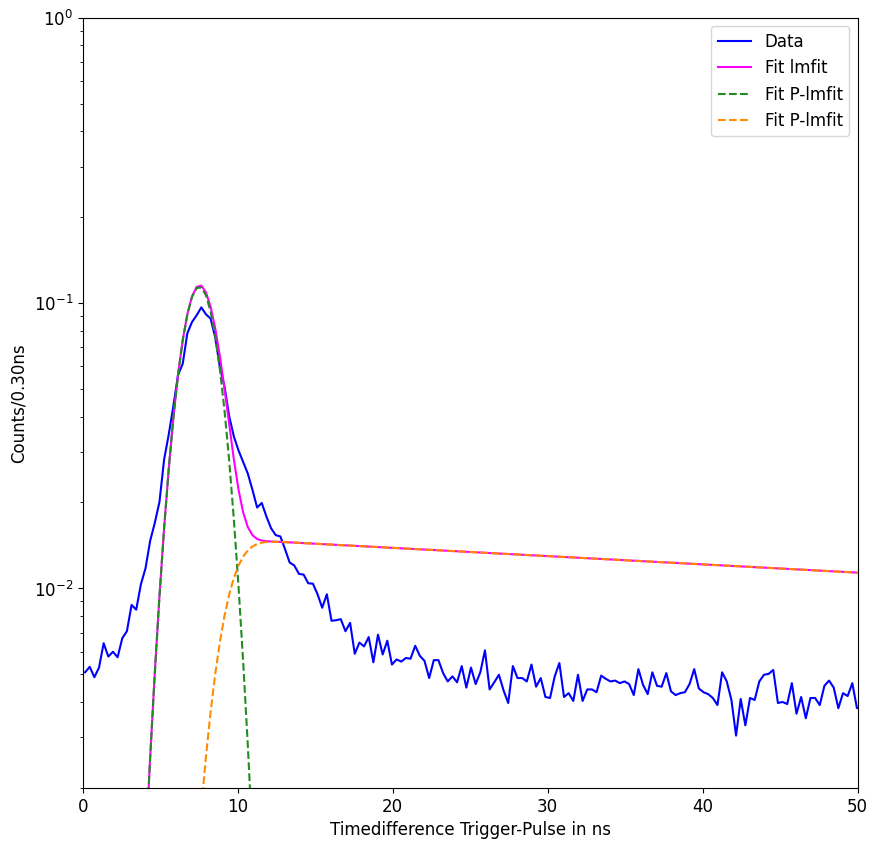

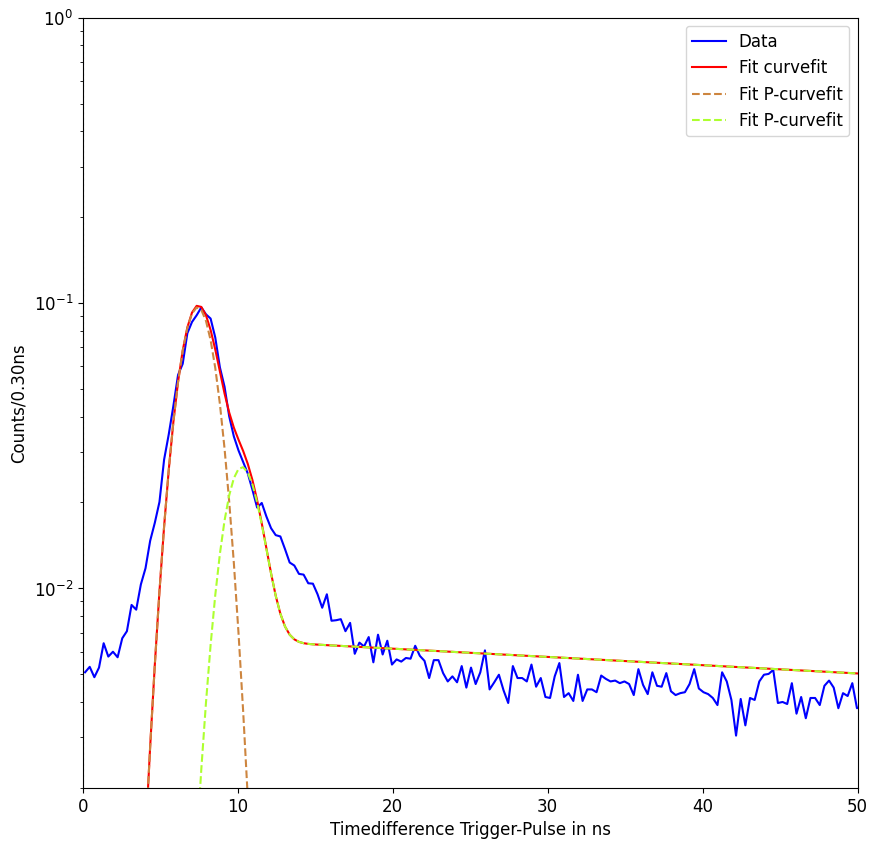

In [40]:
# First load settings
SettingsClear()
LoadSettings("/SiALG_Decoder/PythonSettings")
if "HPLC" in Settings['Files']['Vessel']: 
    LoadSettings("/SiALG_Decoder/PythonSettings_HPLC")
elif "LAB" in Settings['Files']['Vessel']:
    LoadSettings("/SiALG_Decoder/PythonSettings_LAB")
elif "WbLS" in Settings['Files']['Vessel']:
    LoadSettings("/SiALG_Decoder/PythonSettings_WbLS")
#pprint.pprint(Settings)

# Read file paths from the specified file
data_array = {}
with open(Settings['Files']['Path_In'], 'r') as files:
    for file_path in files:
        file_path = (file_path.strip() + "Analysis.root").replace("/mnt/s","..")

        for i_ch in [2,3,4,5,6,7]:
            ReturnedRootFile = GetBranchFromTree(file_path,Settings['Files']['Branchname']+str(i_ch))
            if i_ch not in data_array:
                data_array.update({i_ch: ReturnedRootFile})
            else:
                data_array[i_ch] = np.append(data_array[i_ch], ReturnedRootFile)
    
    for i_transfer in [2,3,4,5,6,7]:
        temp_data = data_array[i_transfer]
        if 404 not in data_array:
            data_array.update({404: temp_data})
        else:
            data_array[404] = np.append(data_array[404], temp_data)

# for key,data in data_array.items():
data = data_array[404]
if "HPLC" in Settings['Files']['Path_In']: 
    Do_Work_for_HPLC(data)
elif "LAB" in Settings['Files']['Path_In']:
    Do_Work_For_LAB(data)
elif "WbLS" in Settings['Files']['Path_In']:
    Do_Work_For_WbLS(data)